In [1]:
from argparse import ArgumentParser
from snewpy import to_snowglobes
from snewpy import run_snowglobes
from snewpy import from_snowglobes
import tarfile
import numpy as np
import os
from astropy.io import ascii
from astropy import units as u
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib as mpl

from snewpy.neutrino import Flavor, MassHierarchy
from snewpy.models import Analytic3Species
from snewpy.flavor_transformation import NoTransformation, AdiabaticMSW, ThreeFlavorDecoherence

mpl.rc('font', size=14)

home_directory = os.getcwd()
SNOwGLoBES_path = "/path/to/snowglobes/" #where snowglobes is located
SNEWPY_models_base = "/path/to/snewpy/models/" #where models (aka input for to_snowglobes) is located


model_folder = "{0}/AnalyticFluence/".format(SNEWPY_models_base)     
try:
    os.mkdir(model_folder)
except OSError as e:
    print(model_folder)
    print("Analytic folder already exists or path is wrong")
else:
    print("Analytic folder made")

/Users/evanoc/Documents/GitHub/supernova_models/models//AnalyticFluence/
Analytic folder already exists or path is wrong


Example of creating a SN model file for a 1-zone analytic fluence modelled after the Livermore model in SNOwGLoBES
======

In [4]:
#livermore, these numbers _almost_ reproduce the livermore model in snowglobes
#they are obtained by calculating the total L, <E> and <E^2> from the livermore
#fluence file (which is modelled after a 10kpc supernovae)
total_energy = (5.478e+52,5.485e+52,4*5.55e+52)
mean_energy = (11.5081, 15.4678, 21.0690)
rms_or_pinch = "rms"
rms_energy = (12.8788,17.8360,  24.3913)


#make an astropy table with two times, 0s and 1s, with constant neutrino properties
table = Table()
table['TIME'] = np.linspace(0,1,2)
table['L_NU_E'] =  np.linspace(1,1,2)*total_energy[0]
table['L_NU_E_BAR'] = np.linspace(1,1,2)*total_energy[1]
table['L_NU_X'] = np.linspace(1,1,2)*total_energy[2]/4. #Note, L_NU_X is set to 1/4 of the total NU_X energy
        
table['E_NU_E'] = np.linspace(1,1,2)*mean_energy[0]
table['E_NU_E_BAR'] = np.linspace(1,1,2)*mean_energy[1]
table['E_NU_X'] = np.linspace(1,1,2)*mean_energy[2]

if rms_or_pinch == "rms":
    table['RMS_NU_E'] = np.linspace(1,1,2)*rms_energy[0]
    table['RMS_NU_E_BAR'] = np.linspace(1,1,2)*rms_energy[1]
    table['RMS_NU_X'] = np.linspace(1,1,2)*rms_energy[2]
    table['ALPHA_NU_E'] = (2.0 * table['E_NU_E'] ** 2 - table['RMS_NU_E'] ** 2) / (
        table['RMS_NU_E'] ** 2 - table['E_NU_E'] ** 2)
    table['ALPHA_NU_E_BAR'] = (2.0 * table['E_NU_E_BAR'] ** 2 - table['RMS_NU_E_BAR'] ** 2) / (
        table['RMS_NU_E_BAR'] ** 2 - table['E_NU_E_BAR'] ** 2)
    table['ALPHA_NU_X'] = (2.0 * table['E_NU_X'] ** 2 - table['RMS_NU_X'] ** 2) / (
        table['RMS_NU_X'] ** 2 - table['E_NU_X'] ** 2)
elif rms_or_pinch == "pinch":
    table['ALPHA_NU_E'] = np.linspace(1,1,2)*pinch_values[0]
    table['ALPHA_NU_E_BAR'] = np.linspace(1,1,2)*pinch_values[1]
    table['ALPHA_NU_X'] = np.linspace(1,1,2)*pinch_values[2]
    table['RMS_NU_E'] = np.sqrt((2.0 + table['ALPHA_NU_E'])/(1.0 + table['ALPHA_NU_E'])*table['E_NU_E']**2)
    table['RMS_NU_E_BAR'] =  np.sqrt((2.0 + table['ALPHA_NU_E_BAR'])/(1.0 + table['ALPHA_NU_E_BAR'])*table['E_NU_E_BAR']**2)
    table['RMS_NU_X'] = np.sqrt((2.0 + table['ALPHA_NU_X'])/(1.0 + table['ALPHA_NU_X'])*table['E_NU_X']**2 )
else:
    print("incorrect second moment method: rms or pinch")

filename = "AnalyticFluence_demo.dat"
table.write(model_folder+"/"+filename,format='ascii',overwrite=True)

Visualize Analytic Model
==

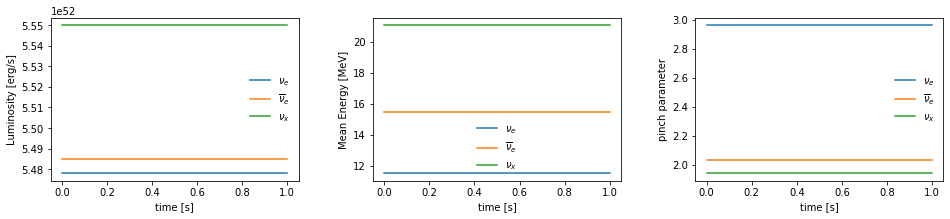

In [5]:
filename = "AnalyticFluence_demo.dat"
model = Analytic3Species(model_folder+"/"+filename)
flavors = [Flavor.NU_E,Flavor.NU_E_BAR,Flavor.NU_X]

fig,axes = plt.subplots(1,3,figsize=(16,3))
plt.subplots_adjust(wspace=0.3)
for flavor in flavors:
    axes[0].plot(model.time,model.luminosity[flavor],label=flavor.to_tex())
axes[0].set_ylabel("Luminosity [erg/s]")
axes[0].set_xlabel("time [s]")
axes[0].legend(frameon=False)

for flavor in flavors:
    axes[1].plot(model.time,model.meanE[flavor],label=flavor.to_tex())
axes[1].set_ylabel("Mean Energy [MeV]")
axes[1].set_xlabel("time [s]")
axes[1].legend(frameon=False)

for flavor in flavors:
    axes[2].plot(model.time,model.pinch[flavor],label=flavor.to_tex())
axes[2].set_ylabel("pinch parameter")
axes[2].set_xlabel("time [s]")
axes[2].legend(frameon=False)

In [13]:
#set model type as 
modeltype = 'Analytic3Species'
#set model file we just created above
filename = "AnalyticFluence_demo.dat"

#set desired Oscillation scenario, snowglobes default is
#NoTransformation, so that is used here to match the output of
#./supernova.pl livermore water wc100kt30prct
transformation = "NoTransformation"

#set distance in kpc
distance=10

#set desired detector
detector='wc100kt30prct'

#Running the SNEWPY/SNOwGLoBES modules
outfile = "Analytic3Species_demo"

#first generated integrated fluence files for SNOwGLoBES
print("Preparing fluences...")
tarredoutfile = to_snowglobes.generate_fluence(model_folder, filename, modeltype, transformation, distance, outfile) #runs to_snowglobes
print("Done fluences...")

#run the fluence file through snowglobes 
print("Running snowglobes...")
run_snowglobes.go(SNOwGLoBES_path, model_folder, tarredoutfile,detector_input=detector)
print("Done snowglobes...")

print("Collating...")
tables = from_snowglobes.collate(SNOwGLoBES_path, model_folder, tarredoutfile, detector_input=detector, skip_plots=True,return_tables=True)
print()
totalcounts = 0
for i in range(1,6):
    print("Number of events of type",tables['Collated_'+outfile+'_'+detector+'_events_smeared_weighted.dat']['header'].split()[i],end=': ')
    counts = sum(tables['Collated_'+outfile+'_'+detector+'_events_smeared_weighted.dat']['data'][i])
    totalcounts += counts
    print(counts)
print("Total number of events: ",totalcounts)

Preparing fluences...
Done fluences...
Running snowglobes...
Calculations are 100.0% completed. ( 1  of  1 )
Done snowglobes...
Collating...

Number of events of type nc_: 498.30314728900004
Number of events of type *_e_: 900.9993460564571
Number of events of type ibd: 26630.266944419996
Number of events of type nue_O16: 41.09845202974501
Number of events of type nuebar_O16: 668.6624835515
Total number of events:  28739.3303733467


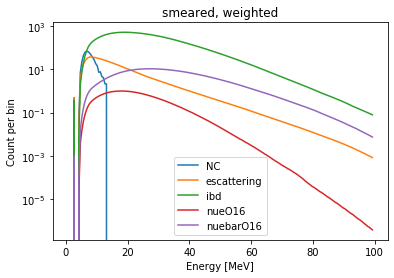

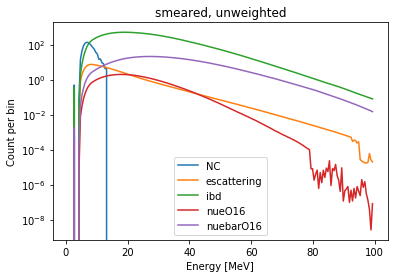

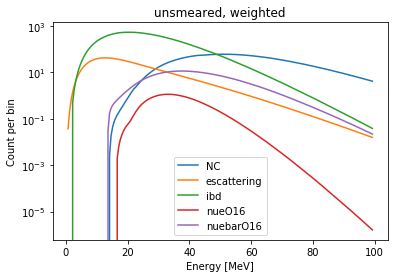

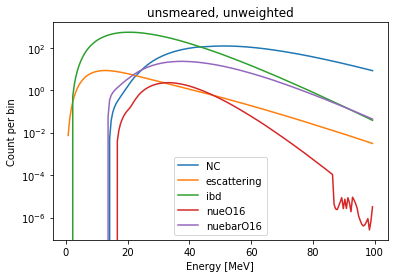

In [17]:
for smear in ["smeared", "unsmeared"]:
    for weight in ["weighted", "unweighted"]:
        energy = tables['Collated_'+outfile+'_'+detector+'_events_'+smear+'_'+weight+'.dat']['data'][0]*1000.
        nc = tables['Collated_'+outfile+'_'+detector+'_events_'+smear+'_'+weight+'.dat']['data'][1]
        escattering = tables['Collated_'+outfile+'_'+detector+'_events_'+smear+'_'+weight+'.dat']['data'][2]
        ibd = tables['Collated_'+outfile+'_'+detector+'_events_'+smear+'_'+weight+'.dat']['data'][3]
        nueO16 = tables['Collated_'+outfile+'_'+detector+'_events_'+smear+'_'+weight+'.dat']['data'][4]
        nuebarO16 = tables['Collated_'+outfile+'_'+detector+'_events_'+smear+'_'+weight+'.dat']['data'][5]
        plt.plot(energy,nc,label="NC")
        plt.plot(energy,escattering,label="escattering")
        plt.plot(energy,ibd,label="ibd")
        plt.plot(energy,nueO16,label="nueO16")
        plt.plot(energy,nuebarO16,label="nuebarO16")
        plt.legend()
        plt.title(smear+", "+weight)
        plt.xlabel("Energy [MeV]")
        plt.ylabel("Count per bin")
        plt.yscale('log')
        plt.show()